In [1]:
import sys
sys.path.append('modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from importlib import reload
import pickle
from Bio import SeqIO
import scipy.io as sio
import scipy
sns.set_style('white')
from importlib import reload
from scipy import stats
import re
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from collections import defaultdict
import logomaker
from Bio import motifs as mots
import glob
import matplotlib
from scipy.ndimage.filters import gaussian_filter1d
import figures as fg
import general_figures as gn
import statsmodels.api as sm
from itertools import repeat
from collections import defaultdict
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import math
from collections import Counter
plt.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42
import scikit_posthocs as sp


# Data Prep

In [2]:
by_facs = {'Gal4':{'Full':3.31, 'Gal4AD': 3.341, 'Gcn4AD': 3.341},
          'Gcn4':{'Full': 3.27, 'Gal4AD': 3.32 , 'Gcn4AD': 3.32 },
          'Mig3':{'Full':3.26, 'Gal4AD':3.32 , 'Gcn4AD': 3.32 },
          'Yap1':{'Full':3.31, 'Gal4AD':3.3 , 'Gcn4AD':3.3 },
          'Msn2':{'Full':3.592, 'Gal4AD':3.62 , 'Gcn4AD':3.62 },}
directions = {'Msn2':['upregulated','upregulated','upregulated'],
            'Mig3':['downregulated','upregulated','upregulated'],
             'Yap1':['upregulated','upregulated','upregulated'],
            'Gal4':['upregulated','upregulated','upregulated'],
            'Gcn4':['upregulated','upregulated','upregulated']}

data = pd.read_pickle('data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']

gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro= data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_check = data.drop(aro_targets)


nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]


#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]

rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]



opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan
opn = gn.prepare_opn(opn)
opn = opn.loc[bins.index[:-1]]

In [3]:
thresh = 3
reload(fg)

binding_gcn4, rna_gcn4, top50_gcn4, fam_gcn4, wt_gcn4 = fg.get_data('Gcn4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_gal4, rna_gal4, top50_gal4, fam_gal4, wt_gal4 = fg.get_data('Gal4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_yap1, rna_yap1, top50_yap1, fam_yap1, wt_yap1 = fg.get_data('Yap1', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_msn2, rna_msn2, top50_msn2, fam_msn2, wt_msn2 = fg.get_data('Msn2', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_mig3, rna_mig3, top50_mig3, fam_mig3, wt_mig3 = fg.get_data('Mig3', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)



cmap = matplotlib.cm.get_cmap('YlOrRd')
tops = {'Msn2':top50_msn2, 'Gal4':top50_gal4, 'Gcn4':top50_gcn4, 'Mig3':top50_mig3, 'Yap1':top50_yap1}
individuals = {'Msn2':['TPS2', 'HOR7'], 'Gal4':['GAL10', 'GAL7'], 'Gcn4':['ARG56', 'CPA2'], 'Mig3':['HXT2', 'MIG2'], 'Yap1':['TRX2', 'YDL124W']}
wts = {'Msn2':wt_msn2, 'Gal4':wt_gal4, 'Gcn4':wt_gcn4, 'Mig3':wt_mig3, 'Yap1':wt_yap1}

all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Yap1',
 'Mig3',
 'Dot6',
 'Abf1',
 'Crz1',
 'Gal4',
 'Gln3',
 'Reb1',
 'Msn2',
 'Met31',
 'Rpn4',
 'Sko1',
 'Ino2',
 'Gcn4',
 'Cst6']

lab_dat = data_waro.filter(regex='|'.join(all_tfs)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]


tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]).filter(regex='deletions')
tfs_binding_deletions_tef = pd.concat([tfs_binding_deletions_tef.filter(regex='{}'.format(i)) for i in ['Full', 'Gal4AD', 'Gcn4AD']], axis=1)

In [4]:
summary_stat_d = dict()
for tf in TFS:
    summary_stat_d[tf]= gn.prepare_data(tf, tfs_binding_deletions_tef, rna_libs, data_waro, bins)



In [5]:
ordered_df = pd.concat([tfs_binding_deletions_tef.filter(regex='^{}'.format(i)) for i in TFS], axis=1)
ordered_df.columns = ['_'.join(k.split('_')[0:2]) for k in ordered_df.columns.values]


# Supplementary

Text(0, 0.5, "Pearson's r")

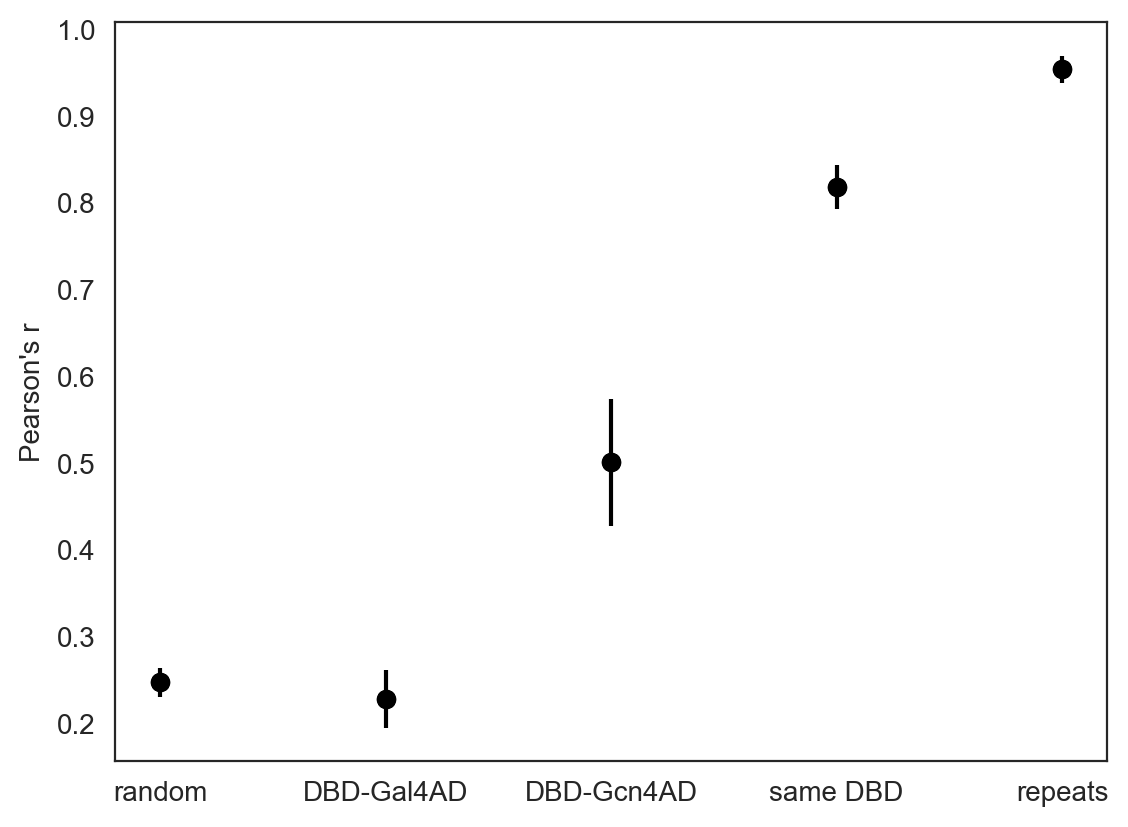

In [6]:
supp_df = pd.concat([tfs_binding_deletions_tef.filter(regex='^{}'.format(i)) for i in TFS], axis=1)
rand = supp_df.corr().replace(1, math.nan).values.reshape(1,-1)[0]
rand = rand[~np.isnan(rand)]
repeats_corrs = [float(name.split('_')[-2]) for name in supp_df.filter(regex='DBD').columns]
ad_corr = lambda x : np.triu(supp_df.filter(regex='DBD').filter(regex=x).corr().values, k=1)[np.triu(supp_df.filter(regex='DBD').filter(regex=x).corr().values, k=1) != 0]
dbdcorr = lambda x: supp_df.filter(regex='DBD').filter(regex='^{}'.format(x)).corr().values[0,1]
dbdcorrdf = pd.DataFrame(zip(TFS, map(dbdcorr, TFS)))
reprd = pd.concat([dbdcorrdf,dbdcorrdf], axis=0)
reprd.loc[:, 'repeats'] = repeats_corrs

from scipy.stats import sem

e = list(sem(reprd.iloc[:, 1:].values))
x = [3,4,1,2,0]
y = list(reprd.iloc[:, 1:].mean().values)
y.append(ad_corr('Gal4AD').mean())
y.append(ad_corr('Gcn4AD').mean())
y.append(np.median(rand))

e.append(sem(ad_corr('Gal4AD')))
e.append(sem(ad_corr('Gcn4AD')))
e.append(sem(rand))


fig, ax = plt.subplots(1)
ax.scatter(x,y, color='k')
ax.errorbar(x,y, yerr=e, fmt='o', color='k')

ax.set_xticks([0,1,2,3,4], labels=['random', 'DBD-Gal4AD', 'DBD-Gcn4AD', 'same DBD', 'repeats'])
ax.set_ylabel('Pearson\'s r')
# fig.savefig('after_gm/fig4/supp_corr_repeats_dbds.pdf', bbox_inches = 'tight')

Text(0, 0.5, 'Variant \n median OPN score')

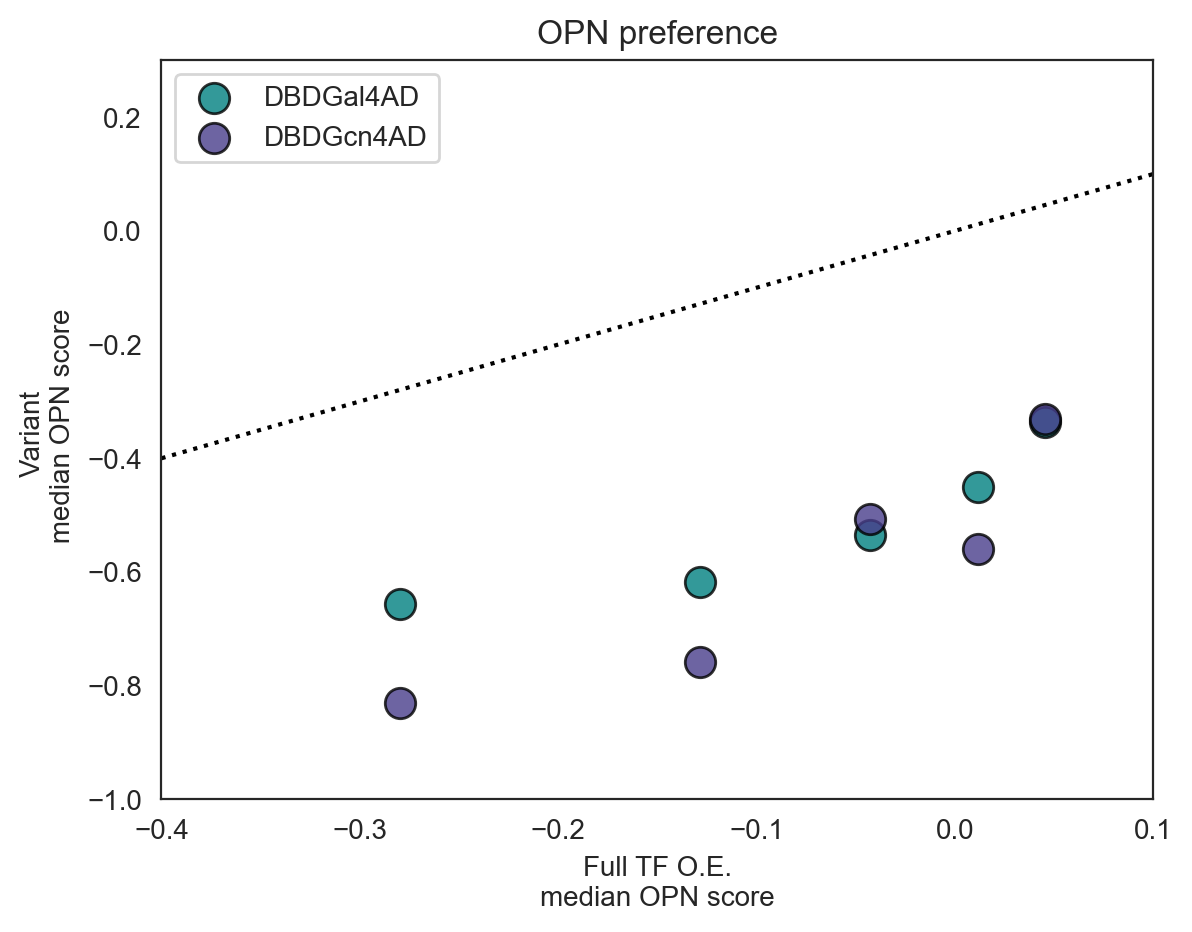

In [8]:
med_opn = fg.get_targets_df(pd.concat([lab_dat.loc[:, ['Msn2','Gal4', 'Gcn4', 'Yap1', 'Mig3']], supp_df, ], axis=1),3,'all', opn.loc[bins.index[:-1]], '').\
sort_index().applymap(lambda x: opn.opn_score.loc[x].median())
medium_opn = pd.DataFrame(med_opn.values.reshape(-1,4), index=['Gal4', 'Gcn4', 'Mig3', 'Msn2', 'Yap1'], columns=['lab', 'Gal4AD', 'Gcn4AD', 'Full OE']).transpose()
fig, ax = plt.subplots(1,)
x = medium_opn.loc['Full OE',:]
c = ['teal', 'darkslateblue', 'seagreen']
l = ['DBDGal4AD', 'DBDGcn4AD', 'Full OE']
for i in [1,2]:
    ax.scatter(x, medium_opn.iloc[i, :], c=c[i-1], label=l[i-1], s=120, edgecolors='k', alpha=.8, zorder=20)
ax.legend(loc='upper left')
ax.set_xlim([-.4, .1])
ax.set_ylim([-1, .3])
ax.axline((0,0), slope=1, c='k', linestyle=':', zorder=0)
ax.set_title('OPN preference')
ax.set_xlabel('Full TF O.E.\nmedian OPN score')
ax.set_ylabel('Variant \n median OPN score')
# fig.savefig('../after_gm/fig4/supp_OPN_pref.pdf', bbox_inches = 'tight')

# Fig4A

<AxesSubplot: >

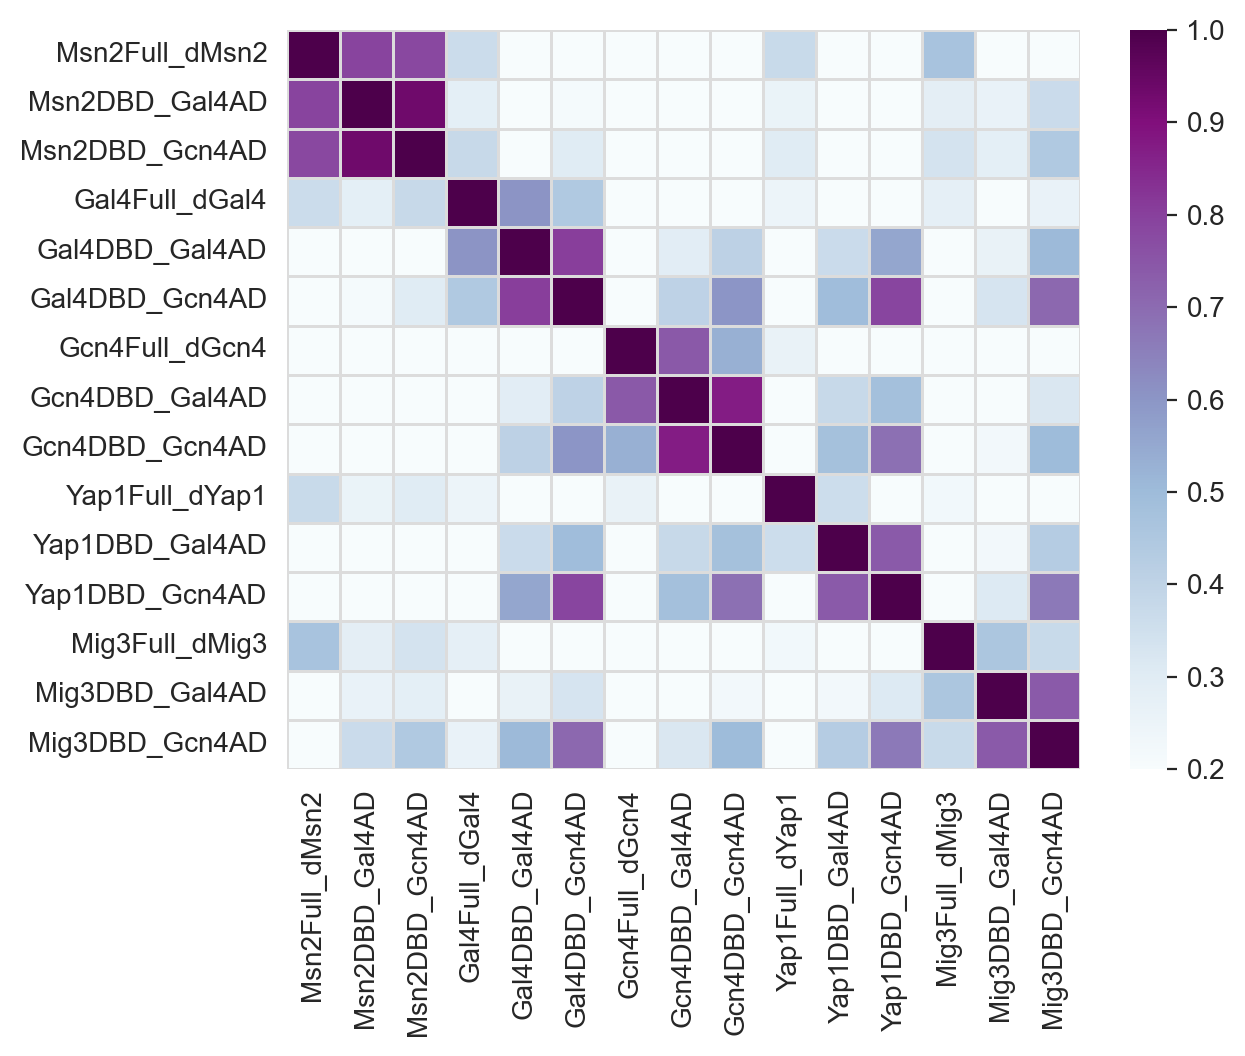

In [9]:
fig, ax = plt.subplots(1)
sns.heatmap(ordered_df.corr(),
            cmap = 'BuPu',
            linewidths=0.5, linecolor='gainsboro', ax=ax, vmin=.2)
# fig.savefig('after_gm/fig4/corrmatrix.pdf', bbox_inches = 'tight')

In [10]:
direct_targets = dict()
for tf in ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']:
    targets = tops[tf]
    curr_corrs = gn.load_corrs(tf)
    targets = set(targets).intersection(set(curr_corrs.loc[sm.stats.multipletests(curr_corrs.pval.values, method='fdr_bh')[0]].index))
    direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
                          'downregulated':curr_corrs.loc[targets].query('spearman<0').index.values}

C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\3477913221.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\3477913221.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'downregulated':curr_corrs.loc[targets].query('spearman<0').index.values}
C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\3477913221.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\3477913221.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'downregul

# Fig4B

In [11]:
allts = fg.get_targets_df(ordered_df, 3, 'all', opn, '')
conc_ts = lambda x: pd.Index(np.concatenate(allts.filter(regex='^'+x, axis=0).loc[:, 'all'].values)).drop_duplicates(keep='first')
f_len = lambda x: allts.filter(regex='^'+x, axis=0).loc[:, 'all'].iloc[0].shape[0]

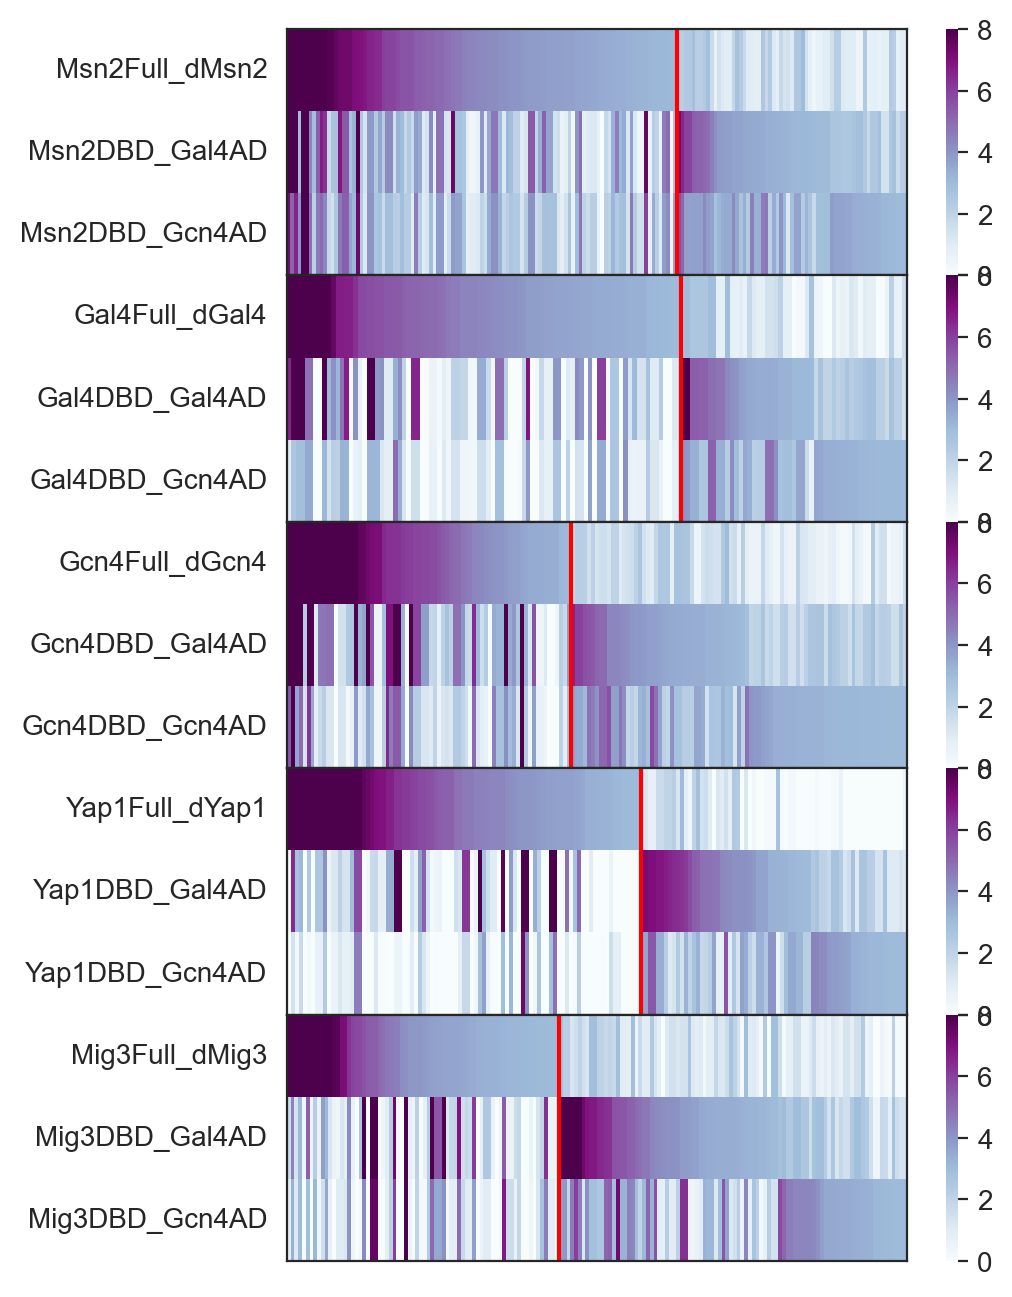

In [12]:
fig, ax = plt.subplots(5,1, figsize=(5,8))

for i, tfi in enumerate(TFS):
    cts = conc_ts(tfi)
    cbind = gn.get_zscored(ordered_df).filter(regex='^'+tfi).loc[cts]
    d = sns.heatmap(cbind.transpose(), cmap='BuPu', vmin=0, vmax=8, ax=ax[i], xticklabels=False)


    for _, spine in d.spines.items():
        spine.set_visible(True)
    ax[i].axvline(f_len(tfi), c='r')
fig.subplots_adjust(hspace=0)
# fig.savefig('after_gm/fig4/binding.pdf', bbox_inches = 'tight')

# Data prep for figures 4D-J

In [13]:
path = 'data/chec_signals/'
signals = os.listdir(path)
files = pd.DataFrame(range(len(signals)), index=signals).filter(regex='700', axis=0)
flexab = pd.read_csv('data/external_datasets/CANDID.csv', header=None)
flexab.index = gp.index
flexab.columns = ['flexability']
# lens = pd.read_csv('/home/labs/barkailab/vovam/sync/Msn2_exression_MiriSagie/Analysis/Chec/frame_for_spcalc.csv')

df_for_sp = pd.read_csv('data/frame_for_spcalc.csv', index_col=0)

df_for_sp = df_for_sp.reset_index()
df_for_sp.index = df_for_sp.name
df_for_sp = pd.DataFrame(df_for_sp.prom_lengths)

In [14]:
dbd_targets = allts.filter(regex='DBD', axis=0)
opnl = list()
bind_wt = list()
bind_dbd = list()
ind_sc = list()
fdr = list()
peaks = list()
flexl = list()
basal = list()
names = list()
for i in TFS:
    ts_dbds=dbd_targets.filter(regex='^'+i, axis=0)
    names.extend(ts_dbds.iloc[0,0])
    names.extend(ts_dbds.iloc[1,0])

    cfc_gal4ad = summary_stat_d[i][0][1].loc[ts_dbds.iloc[0,0]].binding_zscore
    cfc_gcn4ad = summary_stat_d[i][0][2].loc[ts_dbds.iloc[1,0]].binding_zscore

    opnl.extend(opn.loc[cfc_gal4ad.index, 'opn_score'])
    opnl.extend(opn.loc[cfc_gcn4ad.index, 'opn_score'])

    ind_sc.extend(summary_stat_d[i][0][1].loc[ts_dbds.iloc[0,0]].spearman.values)
    ind_sc.extend(summary_stat_d[i][0][2].loc[ts_dbds.iloc[1,0]].spearman.values)

    fdr.extend(summary_stat_d[i][0][1].loc[ts_dbds.iloc[0,0]].fdr_corr.values)
    fdr.extend(summary_stat_d[i][0][2].loc[ts_dbds.iloc[1,0]].fdr_corr.values)

    bind_dbd.extend(cfc_gal4ad.values)
    bind_dbd.extend(cfc_gcn4ad.values)

    bind_wt.extend(summary_stat_d[i][0][0].loc[ts_dbds.iloc[0,0]].binding_zscore.values)
    bind_wt.extend(summary_stat_d[i][0][0].loc[ts_dbds.iloc[1,0]].binding_zscore.values)

    currf = files.filter(regex=i, axis=0).filter(regex='deletions', axis=0).filter(regex='Gal4AD', axis=0).index[0]
    peaks_gal4 = pd.read_pickle(os.path.join(path, currf)).loc[ts_dbds.iloc[0,0]].rolling(window=50, axis=1, center=True).mean(skipna=True).idxmax(axis=1).values
    peaks.extend(peaks_gal4)

    currf = files.filter(regex=i, axis=0).filter(regex='deletions', axis=0).filter(regex='Gcn4AD', axis=0).index[0]
    peaks_gcn4 = pd.read_pickle(os.path.join(path, currf)).loc[ts_dbds.iloc[1,0]].rolling(window=50, axis=1, center=True).mean(skipna=True).idxmax(axis=1).values
    peaks.extend(peaks_gcn4)

    flexl.extend(flexab.loc[ts_dbds.iloc[0,0],'flexability'].values)
    flexl.extend(flexab.loc[ts_dbds.iloc[1,0],'flexability'].values)
    
    basal.extend(by_rna_median.loc[ts_dbds.iloc[0,0], 'BY_61_med'].values)
    basal.extend(by_rna_median.loc[ts_dbds.iloc[1,0], 'BY_61_med'].values)

data_comb = [opnl, bind_wt, bind_dbd, ind_sc, fdr, peaks, flexl, basal, names]
data_comb_index = ['opn', 'bind_wt', 'bind_dbd', 'ind_sc', 'fdr', 'peaks', 'flex', 'basal', 'names']
df_comb = pd.DataFrame(data_comb, index=data_comb_index).transpose().dropna()

pugh = pd.read_csv('data/external_datasets/pugh_vova.csv', header=None)
pugh.index=gp.index

sagie_dat2= pd.read_csv('data/external_datasets/tfs_sumprom.csv')
sagie_dat2.index=gp.index
sagie_dat2 = sagie_dat2.drop(sagie_dat2.filter(regex='Msn2_').columns, axis=1)
sagie_dat2 = sagie_dat2.drop(['Msn2', 'Gal4', 'Gcn4_lowN', 'Yap1', 'Mig3'], axis=1).loc[bins.index[:-1]]
sagie_dat2 = gn.get_zscored(sagie_dat2)>=3


stm = lambda x: True if x=='02_STM' else False
pugh_stm = pugh.applymap(stm)
us_sum = lambda x: sagie_dat2.loc[x,:].sum()

lens_prom = lambda x: df_for_sp.loc[x, 'prom_lengths']

df_comb.loc[:, 'pugh'] = df_comb.names.map(lambda x: pugh_stm.to_dict()[0][x])
df_comb.loc[:, 'us'] = df_comb.names.map(us_sum)
df_comb.loc[:, 'lens'] = df_comb.names.map(lens_prom)


C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\818830936.py:35: FutureWarning: Passing additional kwargs to Rolling.mean has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  peaks_gal4 = pd.read_pickle(os.path.join(path, currf)).loc[ts_dbds.iloc[0,0]].rolling(window=50, axis=1, center=True).mean(skipna=True).idxmax(axis=1).values
C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\818830936.py:39: FutureWarning: Passing additional kwargs to Rolling.mean has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  peaks_gcn4 = pd.read_pickle(os.path.join(path, currf)).loc[ts_dbds.iloc[1,0]].rolling(window=50, axis=1, center=True).mean(skipna=True).idxmax(axis=1).values
C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\818830936.py:35: FutureWarning: Passing additional kwargs to Rolling.mean has no impact on the result and is deprecated. This will raise a TypeError in a future version o

# Fig4D

C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\2482550921.py:4: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  currd_std = (df_comb.loc[:, ['ind_sc', 'bind_wt', 'bind_dbd']].dropna().sort_values(by='ind_sc').rolling(window=wind, center=True).sem()*0.5).dropna()


Text(0.5, 0.98, 'DBD-AD bound promoters')

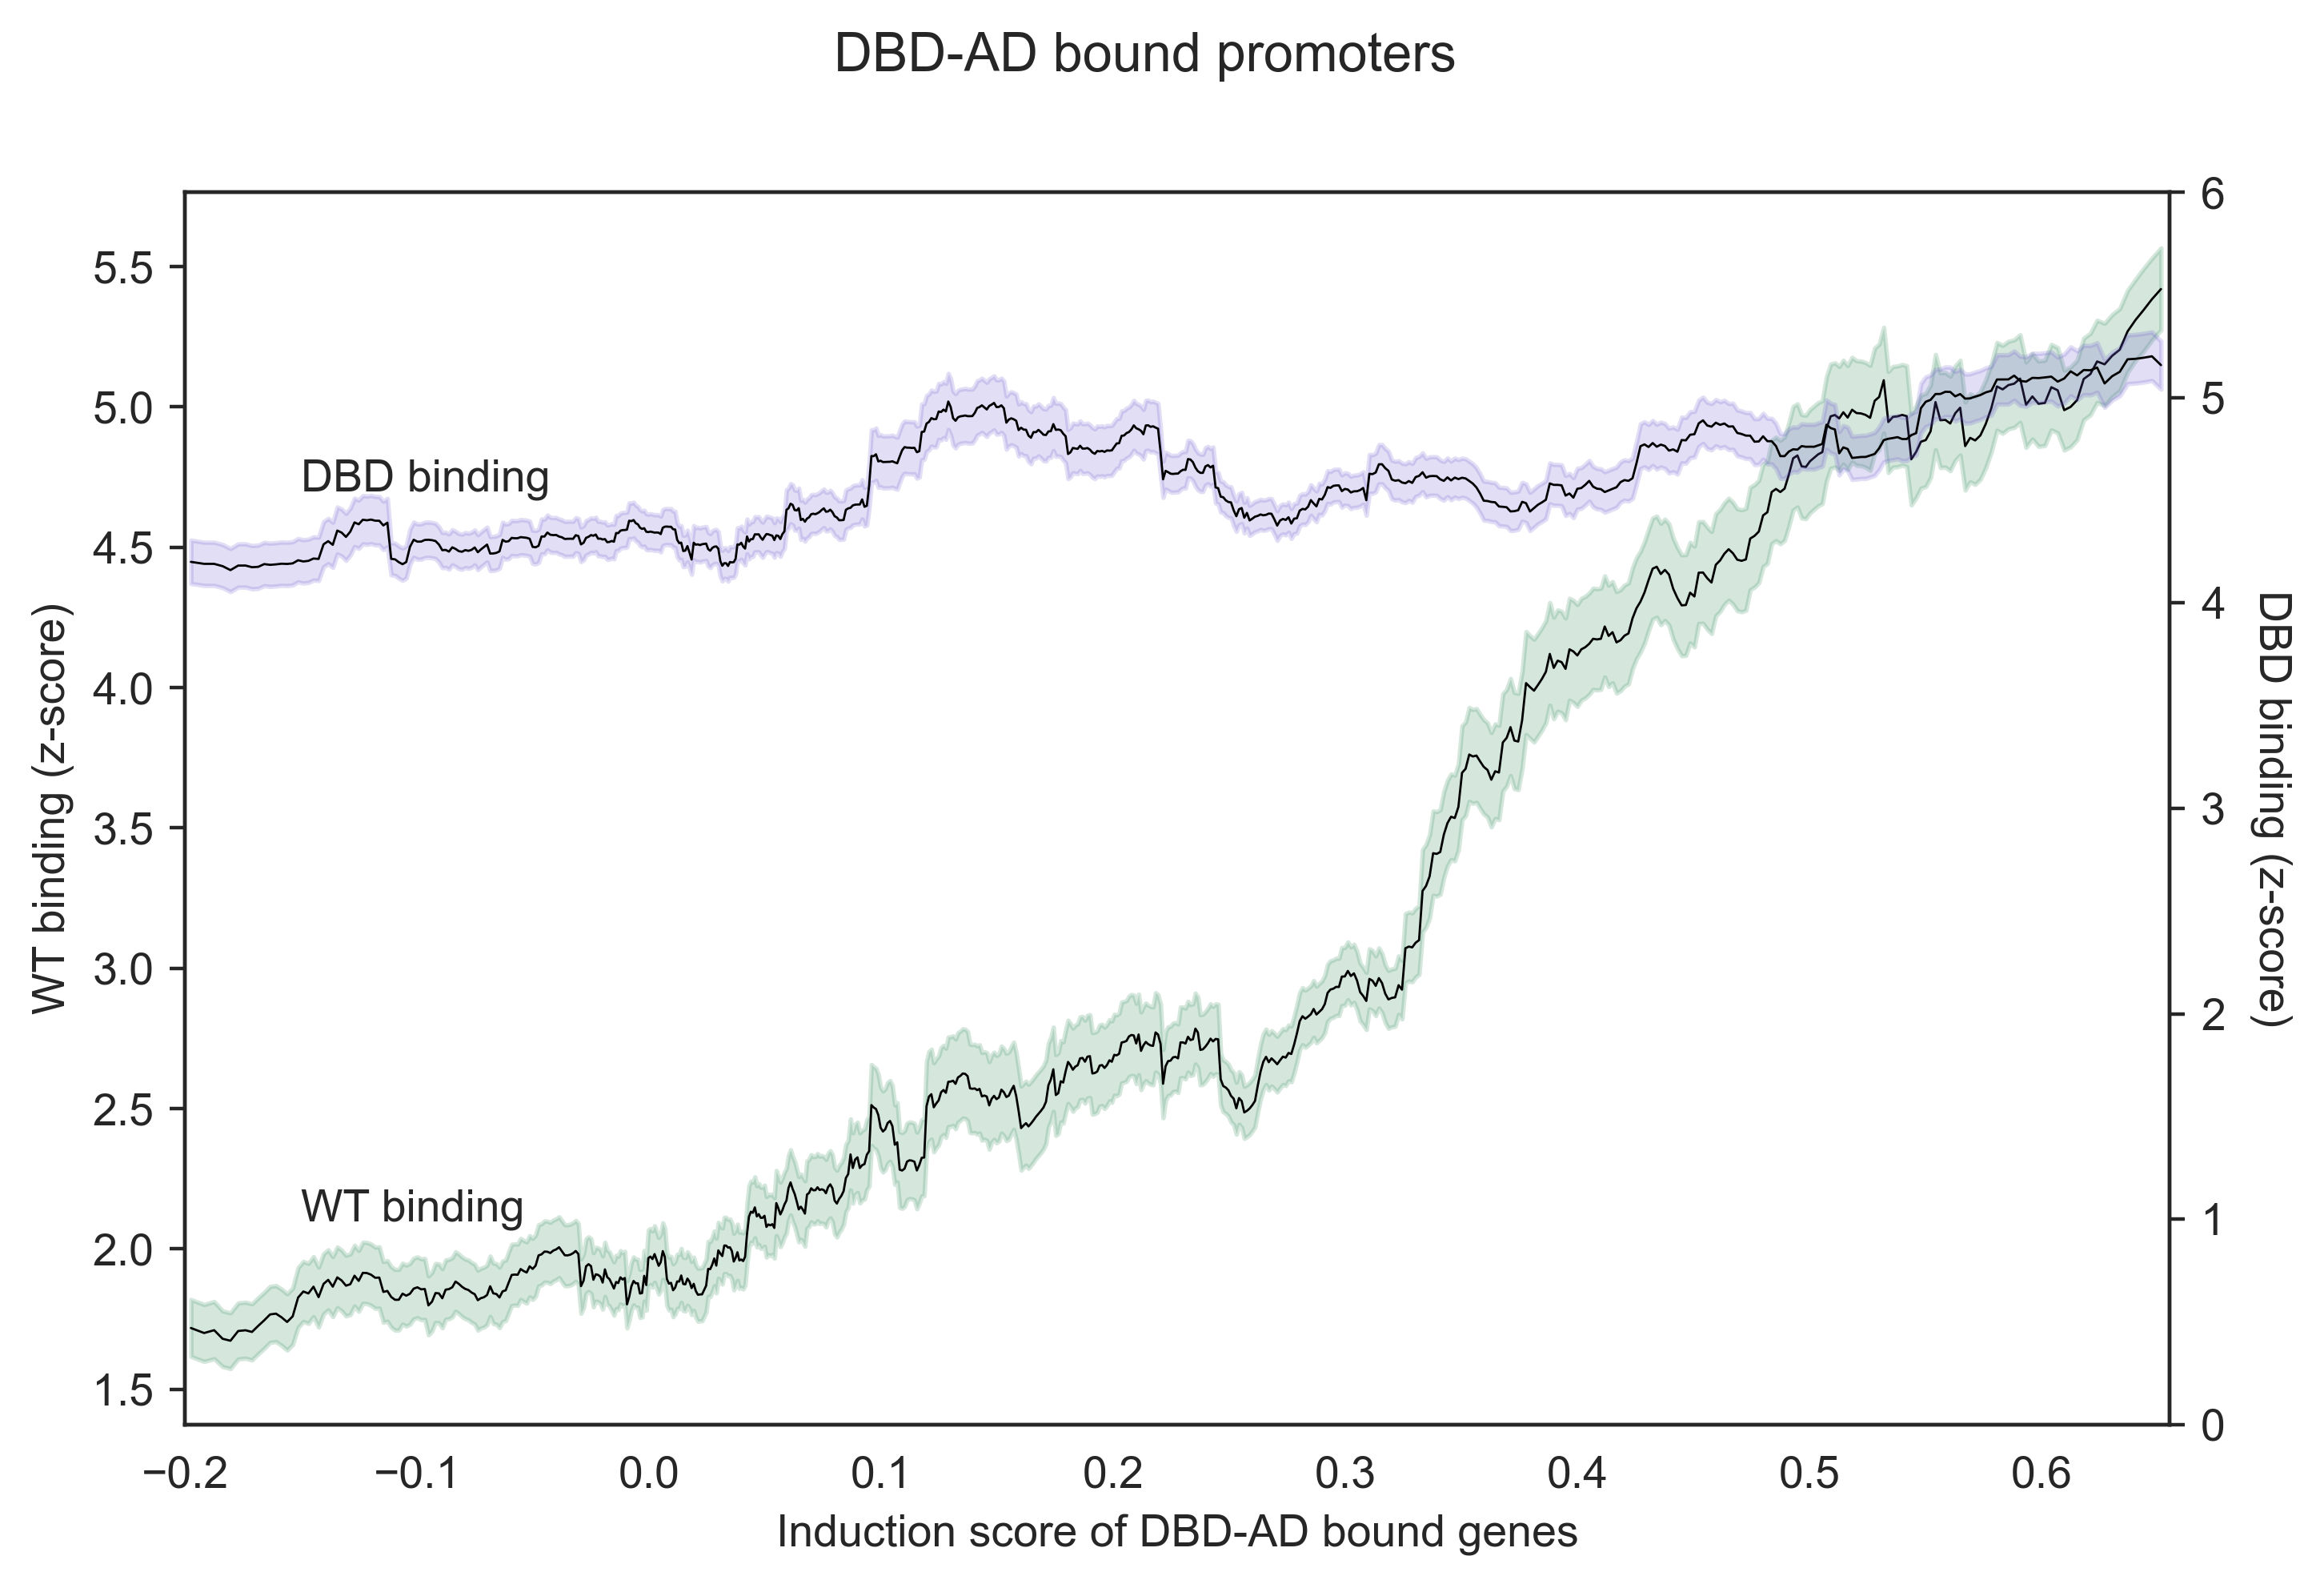

In [18]:
wind = 120

currd_mean = df_comb.loc[:, ['ind_sc', 'bind_wt', 'bind_dbd']].dropna().sort_values(by='ind_sc').rolling(window=wind, center=True).mean().dropna()
currd_std = (df_comb.loc[:, ['ind_sc', 'bind_wt', 'bind_dbd']].dropna().sort_values(by='ind_sc').rolling(window=wind, center=True).sem()*0.5).dropna()

lwt= currd_mean.bind_wt - currd_std.bind_wt
uwt = currd_mean.bind_wt + currd_std.bind_wt

ldbd = currd_mean.bind_dbd - currd_std.bind_dbd
udbd = currd_mean.bind_dbd + currd_std.bind_dbd



fig, ax = plt.subplots(1, figsize=(8,5), dpi=200)
ax.plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'bind_wt'], c='k', linewidth=.5)
ax.fill_between(currd_mean.loc[:,'ind_sc'], lwt, uwt, alpha=0.2, color='seagreen')


ax2 = ax.twinx()
ax2.plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'bind_dbd'], c='k', linewidth=.5)
ax2.fill_between(currd_mean.loc[:,'ind_sc'], ldbd, udbd, alpha=0.2, color='slateblue')

ax2.set_ylim([0,6])
ax2.set_ylabel('DBD binding (z-score)', rotation=270, labelpad=15)

# fig.tight_layout()

ax.text(-0.15, 2.1, 'WT binding')
ax.text(-0.15, 4.7, 'DBD binding')
ax.set_xlim([-0.2, 0.655])
ax.set_xlabel('Induction score of DBD-AD bound genes')
ax.set_ylabel('WT binding (z-score)')
fig.suptitle('DBD-AD bound promoters')
# fig.savefig('after_gm/fig4/wt_dbd_induction.pdf', bbox_inches = 'tight')

# Fig4 e-J

C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\2082579166.py:14: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  currd_std = df_comb.loc[:, ['ind_sc', 'opn', 'peaks', 'flex','basal', 'pugh', 'us']].dropna().\


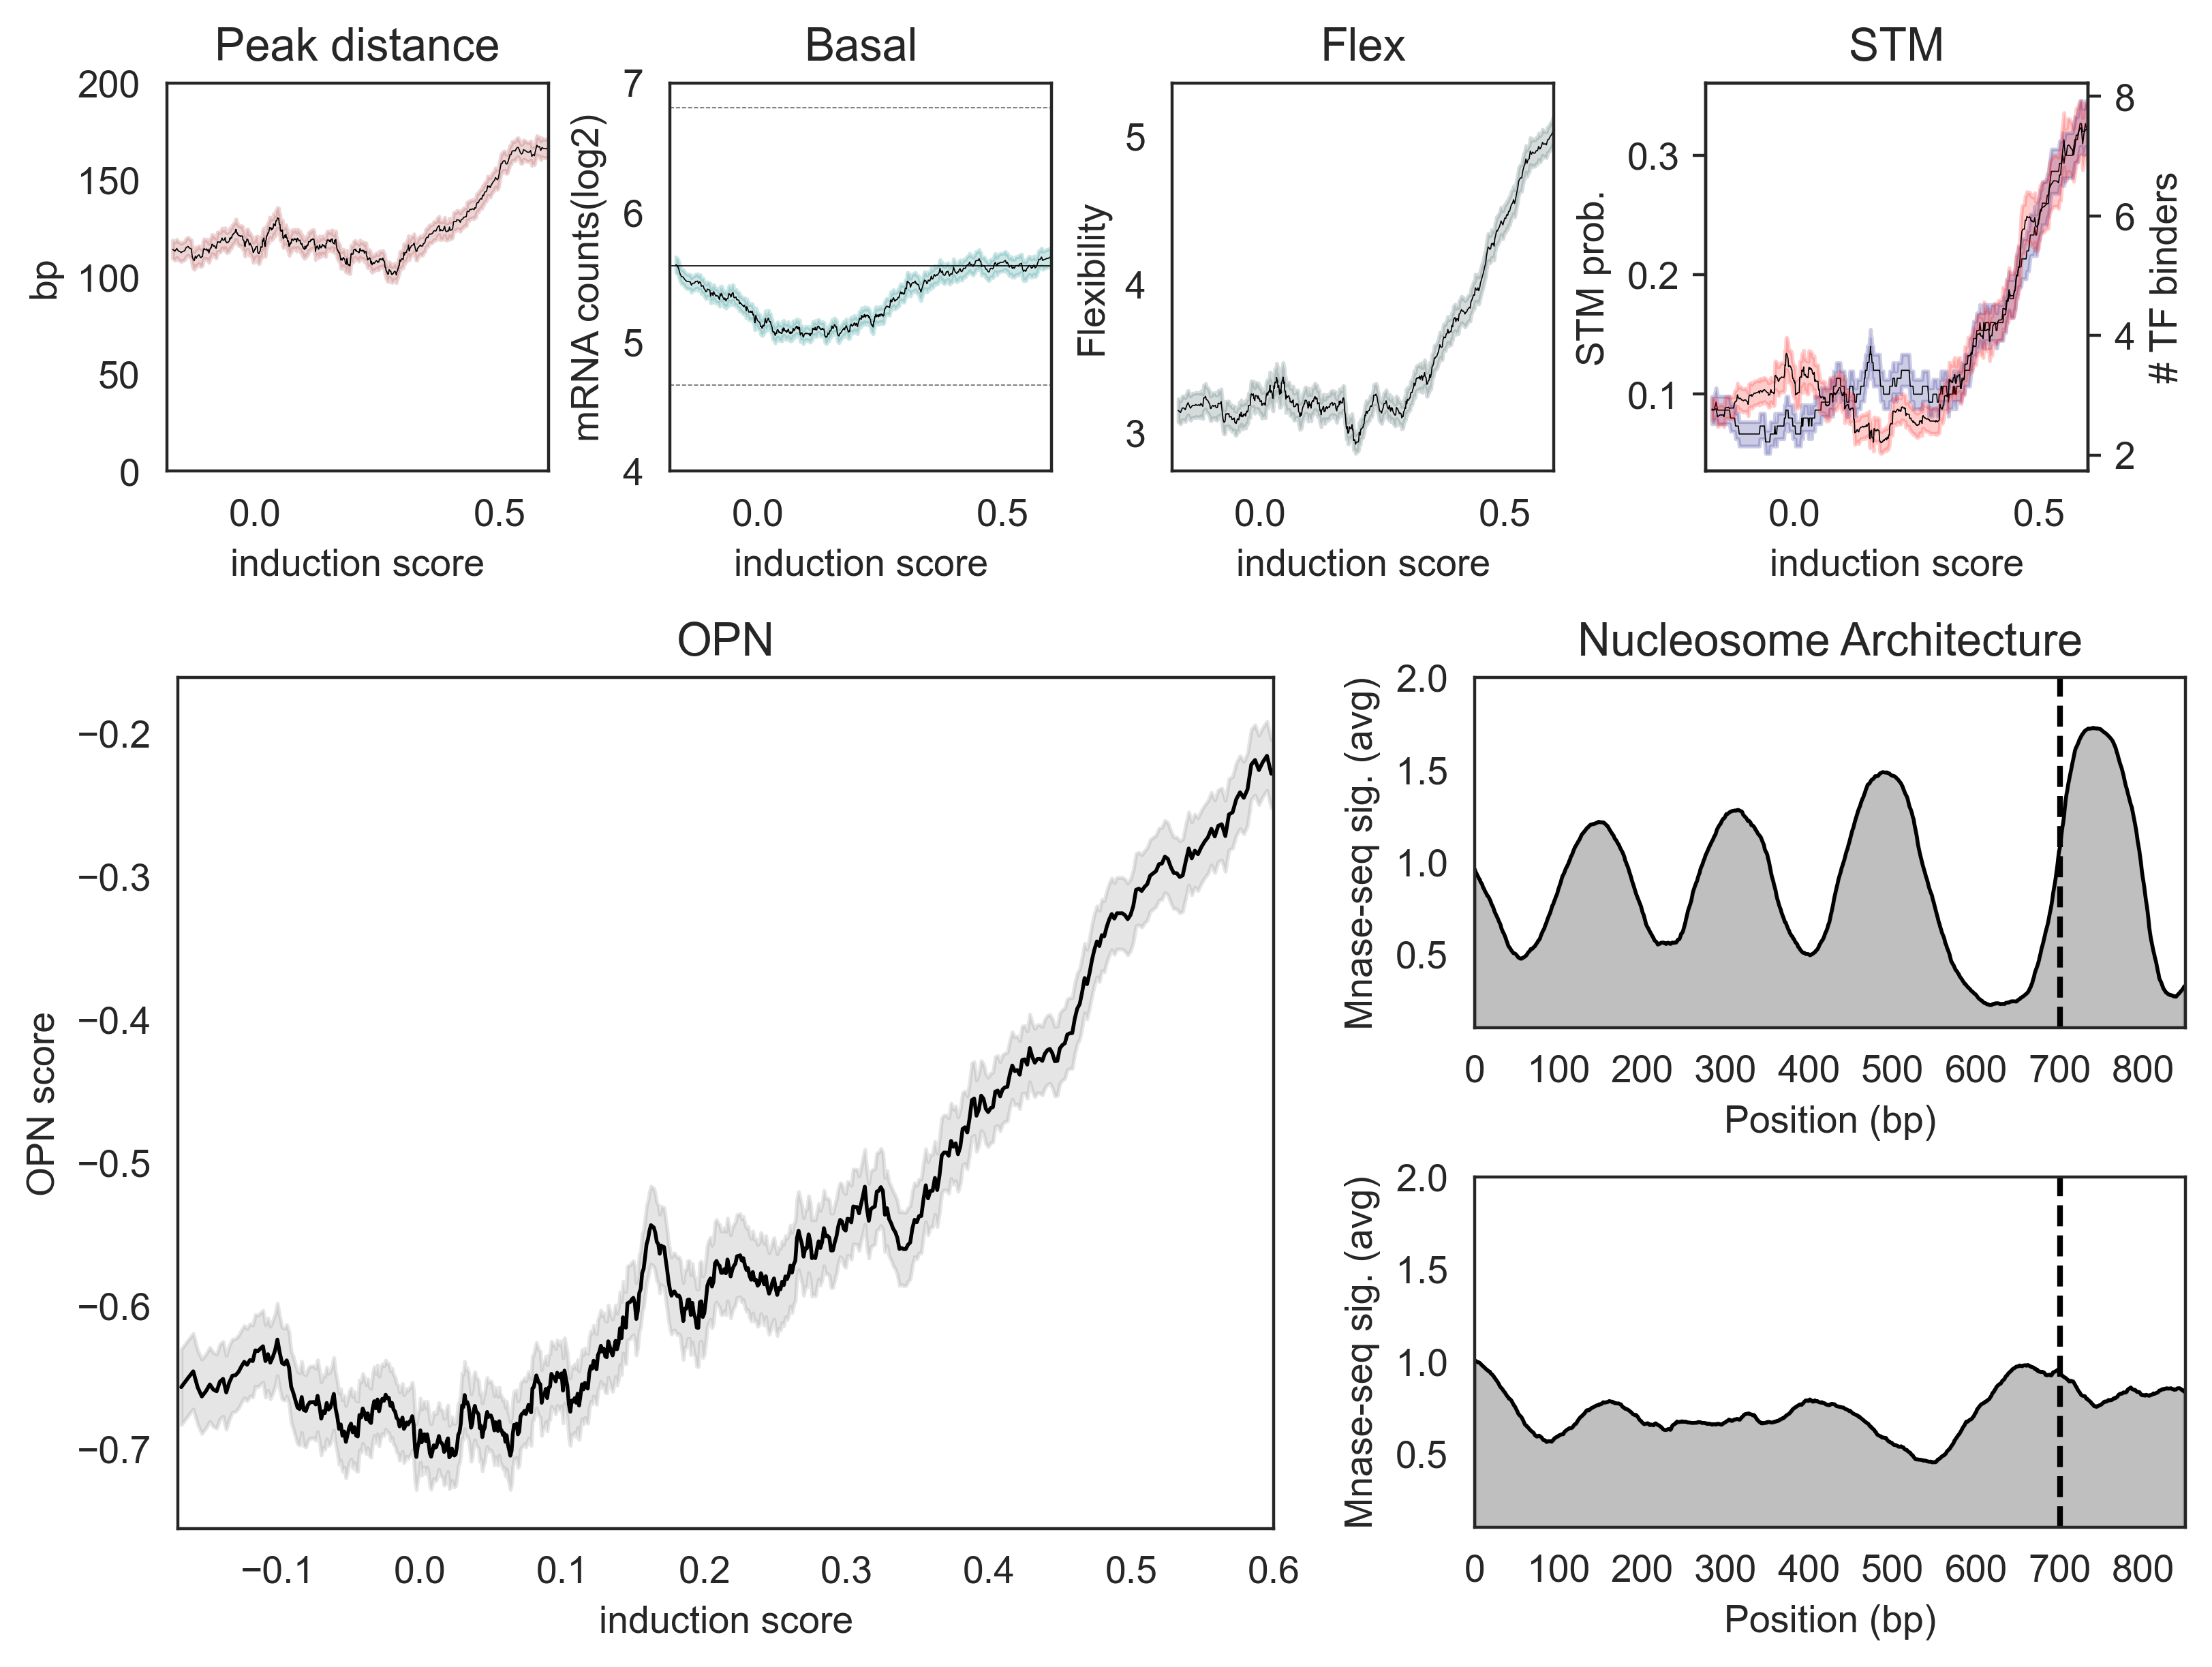

In [19]:
# fig, ax = plt.subplots(1,4, figsize=(10,2), constrained_layout=True)

desc = by_rna_median.describe().filter(regex='%',axis=0)
desc.index = ['25', '50', '75']
desc.columns = ['desc']


fig = plt.figure(figsize=(8,6), constrained_layout=True, dpi=200)
sub = fig.subfigures(2,1, height_ratios=[1,1.8])

wind=150
currd_mean = df_comb.loc[:, ['ind_sc', 'opn', 'peaks', 'flex', 'basal', 'pugh', 'us']].dropna().\
sort_values(by='ind_sc').rolling(window=wind, center=True).mean().dropna()
currd_std = df_comb.loc[:, ['ind_sc', 'opn', 'peaks', 'flex','basal', 'pugh', 'us']].dropna().\
sort_values(by='ind_sc').rolling(window=wind, center=True).sem().dropna()*0.5

lower = currd_mean - currd_std
upper = currd_mean + currd_std

lwid = .3
ax = sub[0].subplots(1,4)
for axi in ax:
    axi.set_xlim([-0.18, 0.6])

ax[0].plot(currd_mean.loc[:,'ind_sc'], 700- currd_mean.loc[:,'peaks'], c='k', linewidth=lwid)
ax[0].fill_between(currd_mean.loc[:,'ind_sc'], 700- lower.loc[:, 'peaks'], 700- upper.loc[:, 'peaks'], alpha=0.2, color='brown')
ax[0].set_title('Peak distance')
ax[0].set_ylim([0,200])
ax[1].plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'basal'], c='k', linewidth=lwid)
ax[1].fill_between(currd_mean.loc[:,'ind_sc'], lower.loc[:, 'basal'], upper.loc[:, 'basal'], alpha=0.2, color='teal')
ax[1].set_title('Basal')

cs = {25:'dimgray', 50:'black', 75:'dimgray'}
ls = {25:'--', 50:'-', 75:'--'}

for i in [25,50,75]:
    ax[1].axhline(desc.loc[str(i)].values[0], c=cs[i], linestyle=ls[i], linewidth=lwid)
ax[1].set_ylim([4, 7], )


ax[2].plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'flex'], c='k', linewidth=lwid)
ax[2].fill_between(currd_mean.loc[:,'ind_sc'], lower.loc[:, 'flex'], upper.loc[:, 'flex'], alpha=0.2, color='darkslategray')
ax[2].set_title('Flex')

ax[3].plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'pugh'], c='k', linewidth=lwid)
ax[3].fill_between(currd_mean.loc[:,'ind_sc'], lower.loc[:, 'pugh'], upper.loc[:, 'pugh'], alpha=0.2, color='navy')

secax3 = ax[3].twinx()
secax3.plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'us'], c='k', linewidth=lwid)
secax3.fill_between(currd_mean.loc[:,'ind_sc'], lower.loc[:, 'us'], upper.loc[:, 'us'], alpha=0.2, color='red')
secax3.set_ylabel('# TF binders')
ax[3].set_title('STM')

labesl = ['bp', 'mRNA counts(log2)', 'Flexibility', 'STM prob.']
for i, axi in enumerate(ax):
    axi.set_xlabel('induction score')
    axi.set_ylabel(labesl[i])
    
    
n_sub = sub[1].subfigures(1,2, width_ratios=[1.5,1])
ax = n_sub[0].subplots(1)
ax.plot(currd_mean.loc[:,'ind_sc'], currd_mean.loc[:,'opn'], c='k', linewidth=1)
ax.fill_between(currd_mean.loc[:,'ind_sc'], lower.loc[:, 'opn'], upper.loc[:, 'opn'], alpha=0.2, color='gray')
ax.set_title('OPN')
ax.set_xlabel('induction score')
ax.set_ylabel('OPN score')
ax.set_xlim([-0.17, 0.6])


ax = n_sub[1].subplots(2,1, sharey=True)
genes = pd.Index(df_comb.loc[:, ['ind_sc','names']].dropna().\
sort_values(by='ind_sc').names.values).drop_duplicates()

# genes = pd.Index(df_comb.loc[:, ['opn','names']].dropna().\
# sort_values(by='opn').names.values).drop_duplicates()
av_num = 20

ax[0].plot(nuc_df.loc[genes[:av_num]].mean(), c='k',linewidth=1)
ax[0].fill_between(nuc_df.loc[genes[:av_num]].mean().index,nuc_df.loc[genes[:av_num]].mean(),color='gray',alpha=.5 )
ax[0].set_ylim([0.1,2])
ax[0].set_xlim([0,850])

ax[1].plot(nuc_df.loc[genes[-av_num:]].mean(), c='k', linewidth=1)
ax[1].fill_between(nuc_df.loc[genes[-av_num:]].mean().index,nuc_df.loc[genes[-av_num:]].mean(),color='gray',alpha=.5)
ax[1].set_ylim([0.1,2])
ax[1].set_xlim([0,850])


ax[0].set_xticks(np.arange(0,850,100), labels=np.arange(0,850,100))
ax[1].set_xticks(np.arange(0,850,100), labels=np.arange(0,850,100))
ax[0].set_title('Nucleosome Architecture')

for axi in ax:
    axi.set_xlabel('Position (bp)')
    axi.set_ylabel('Mnase-seq sig. (avg)')
    axi.axvline(700, c='k', linestyle='--')
# fig.savefig('after_gm/fig4/info_panel.pdf', bbox_inches = 'tight')

In [20]:
currd_mean.peaks = 700 - currd_mean.peaks

In [21]:
currd_mean.corr()

,ind_sc,opn,peaks,flex,basal,pugh,us
ind_sc,1.000000,0.919389,0.624136,0.773973,0.606864,0.852909,0.695703
opn,0.919389,1.000000,0.786555,0.909267,0.766911,0.951793,0.848692
peaks,0.624136,0.786555,1.000000,0.946940,0.598419,0.891382,0.957174
flex,0.773973,0.909267,0.946940,1.000000,0.725788,0.954921,0.979018
basal,0.606864,0.766911,0.598419,0.725788,1.000000,0.646662,0.723221
pugh,0.852909,0.951793,0.891382,0.954921,0.646662,1.000000,0.908020
us,0.695703,0.848692,0.957174,0.979018,0.723221,0.908020,1.000000


# Supplementary (Noise)

C:\Users\vovam\AppData\Local\Temp\ipykernel_13376\310348624.py:9: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  currd_std = df_comb.loc[:, ['ind_sc', 'noise']].dropna().\


Text(0, 0.5, 'Noise')

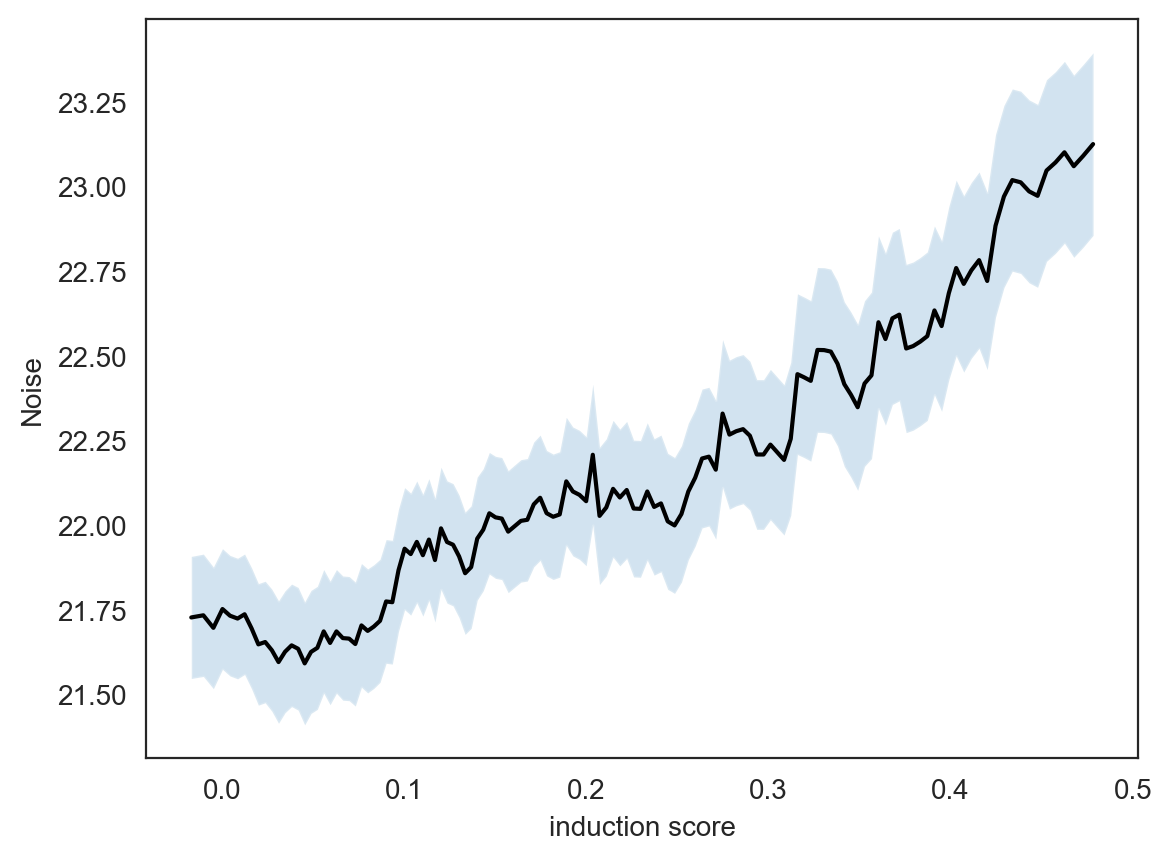

In [22]:
genes = pd.Index(df_comb.loc[:, ['opn','names']].dropna().\
sort_values(by='opn').names.values).drop_duplicates()
params = pd.DataFrame(index = gp.drop('[]').index)
noise = pd.DataFrame(sio.loadmat('data/external_datasets/weissman_noise.mat')['weissman_data'], index=gp.index).loc[bins.index[:-1]]
df_comb.loc[:, 'noise'] = noise.loc[df_comb.names.values].iloc[:,2].values
wind=150
currd_mean = df_comb.loc[:, ['ind_sc', 'noise']].dropna().\
sort_values(by='ind_sc').rolling(window=wind, center=True).mean()
currd_std = df_comb.loc[:, ['ind_sc', 'noise']].dropna().\
sort_values(by='ind_sc').rolling(window=wind, center=True).sem()*0.5

lower = currd_mean - currd_std
upper = currd_mean + currd_std

fig, ax = plt.subplots(1)
ax.plot(currd_mean.ind_sc, currd_mean.noise, c='k')
ax.fill_between(currd_mean.ind_sc, lower.noise, upper.noise, alpha=.2)
ax.set_xlabel('induction score')
ax.set_ylabel('Noise')
# fig.savefig('after_gm/fig4/noise.pdf', bbox_inches = 'tight')

## param df gen

In [17]:
# params.loc[df_for_sp.drop('[]').index, 'prom_len'] = df_for_sp.drop('[]').values
# pugh.columns = ['pugh']
# basal = pd.DataFrame(by_rna.median(axis=1).drop('MNASE'), columns=['basal'])
# opnm = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0).drop('[]')
# sagie_dat2= pd.read_csv('data/external_datasets/tfs_sumprom.csv')
# sagie_dat2.index=gp.index
# sagie_dat2 = sagie_dat2.drop(sagie_dat2.filter(regex='Msn2_').columns, axis=1).drop('[]')
# sagie_dat2 = pd.DataFrame((gn.get_zscored(sagie_dat2)>=3).sum(axis=1))
# sagie_dat2.columns = ['numTFs_bind']
# dep = pd.read_csv('data/external_datasets/dependence_df_20221127.csv',index_col=0).drop('[]')
# gen_params = pd.concat([flexab.drop('[]'), params, pugh.drop('[]'), basal, opnm, sagie_dat2, dep], axis=1)
# gen_params.to_csv('data/params_compendium.csv')